In [1]:
import pandas as pd
import json
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout
from sklearn.metrics import classification_report
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [2]:
def load_data(file_path):
    with open(file_path, 'r', encoding='utf-8') as f:
        data = json.load(f)
    df = pd.DataFrame(data)
    sentences = df['sentence'].tolist()
    bio_tags = []
    for labels in df['labels']:
        tags = [token[1] for token in labels]
        bio_tags.append(tags)
    return sentences, bio_tags

### **1. Tiền xử lý dữ liệu cho mô hình**

In [3]:
train_file = '/kaggle/input/bio-data-dialog/train_output.json'
val_file = '/kaggle/input/bio-data-dialog/val_output.json'
test_file = '/kaggle/input/bio-data-dialog/test_output.json'

train_sentences, train_bio_tags = load_data(train_file)
val_sentences, val_bio_tags = load_data(val_file)
test_sentences, test_bio_tags = load_data(test_file)

# Tokenize và chuẩn hóa dữ liệu
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_sentences + val_sentences + test_sentences)
X_train = tokenizer.texts_to_sequences(train_sentences)
X_val = tokenizer.texts_to_sequences(val_sentences)
X_test = tokenizer.texts_to_sequences(test_sentences)

# Padding cho dữ liệu đầu vào
max_len = max([len(s.split()) for s in train_sentences + val_sentences + test_sentences])  # Tính độ dài câu dài nhất
X_train = pad_sequences(X_train, padding='post', maxlen=max_len)
X_val = pad_sequences(X_val, padding='post', maxlen=max_len)
X_test = pad_sequences(X_test, padding='post', maxlen=max_len)

# Label encoding cho BIO tags
tag_encoder = LabelEncoder()
all_tags = [tag for tags in train_bio_tags + val_bio_tags + test_bio_tags for tag in tags]
unique_tags = set(all_tags)
tag_encoder.fit(list(unique_tags))

# Chuyển đổi nhãn thành các chỉ số
y_train = [tag_encoder.transform(tags) for tags in train_bio_tags]
y_val = [tag_encoder.transform(tags) for tags in val_bio_tags]
y_test = [tag_encoder.transform(tags) for tags in test_bio_tags]

# Padding cho nhãn
y_train = pad_sequences(y_train, padding='post', maxlen=max_len)
y_val = pad_sequences(y_val, padding='post', maxlen=max_len)
y_test = pad_sequences(y_test, padding='post', maxlen=max_len)

### **2. Xây dựng mô hình**

In [4]:
embedding_dim = 100
model = Sequential()
model.add(Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=embedding_dim, input_length=X_train.shape[1]))
model.add(Bidirectional(LSTM(units=64, return_sequences=True)))
model.add(Dropout(0.1))
model.add(Dense(len(tag_encoder.classes_), activation='softmax'))

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(
    X_train, 
    np.expand_dims(y_train, -1),  
    validation_data=(X_val, np.expand_dims(y_val, -1)),  
    epochs=100,
    batch_size=32,  
    callbacks=[early_stopping]  
)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/100
1775/1775 ━━━━━━━━━━━━━━━━━━━━ 18s 7ms/step - accuracy: 0.9552 - loss: 0.2274 - val_accuracy: 0.9912 - val_loss: 0.0323
Epoch 2/100
1775/1775 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.9917 - loss: 0.0290 - val_accuracy: 0.9925 - val_loss: 0.0275
Epoch 3/100
1775/1775 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.9928 - loss: 0.0245 - val_accuracy: 0.9929 - val_loss: 0.0247
Epoch 4/100
1775/1775 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.9933 - loss: 0.0221 - val_accuracy: 0.9931 - val_loss: 0.0240
Epoch 5/100
1775/1775 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.9936 - loss: 0.0204 - val_accuracy: 0.9933 - val_loss: 0.0237
Epoch 6/100
1775/1775 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.9941 - loss: 0.0191 - val_accuracy: 0.9934 - val_loss: 0.0231
Epoch 7/100
1775/1775 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.9943 - loss: 0.0182 - val_accuracy: 0.9934 - val_loss: 0.0235
Epoch 8/100
1775/1775 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.9945 -

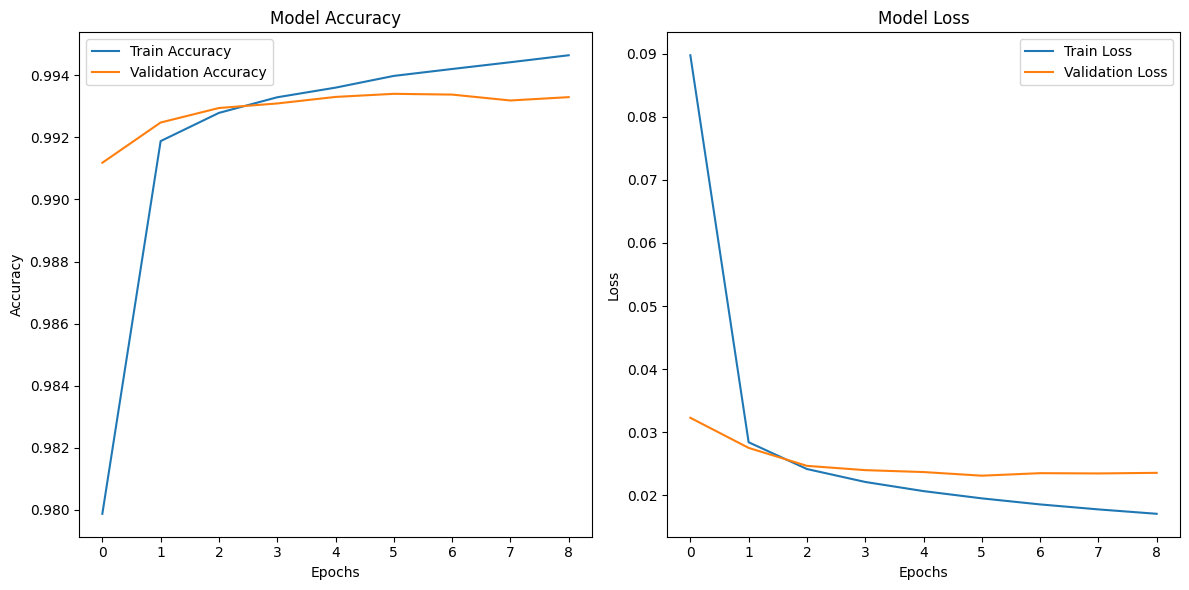

In [5]:
import matplotlib.pyplot as plt
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(train_accuracy, label='Train Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


### **3. Đánh giá mô hình trên tập test**

In [6]:
# Đánh giá mô hình trên dữ liệu test
predictions = model.predict(X_test)
predicted_tags = np.argmax(predictions, axis=-1)

y_true_flat = []
y_pred_flat = []

for true_tags, pred_tags in zip(y_test, predicted_tags):
    for true, pred in zip(true_tags, pred_tags):
        if true != 0:  
            y_true_flat.append(true)
            y_pred_flat.append(pred)

unique_labels = sorted(set(y_true_flat + y_pred_flat))
print("Classification Report:")
print(classification_report(y_true_flat, y_pred_flat, target_names=tag_encoder.classes_, labels=unique_labels))

231/231 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Classification Report:
               precision    recall  f1-score   support

       B-area       0.00      0.00      0.00         0
   B-arriveby       0.92      0.92      0.92       388
    B-bookday       0.90      0.95      0.92       528
 B-bookpeople       0.90      0.94      0.92       791
   B-bookstay       0.88      0.90      0.89       301
   B-booktime       0.93      0.91      0.92       335
        B-day       0.93      0.96      0.95       503
 B-department       0.94      0.93      0.94       547
  B-departure       0.90      0.91      0.90       586
B-destination       0.91      0.91      0.91       422
B-entrancefee       0.91      0.84      0.87       348
       B-food       0.86      0.84      0.85       447
    B-leaveat       0.91      0.93      0.92       557
       B-name       0.94      0.97      0.95       203
 B-pricerange       0.84      0.71      0.77       571
      B-stars       0.76      0.48      0.59        92


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2326: UserWarning: labels size, 29, does not match size of target_names, 34
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_divis

Nhận xét: đa số các nhãn cho độ chính xác cao, một số nhãn có số lượng ít hơn trong tập dữ liệu cho kết quả thấp hơn.

### **4. Lưu lại mô hình đã huấn luyện**

In [7]:
model.save('/kaggle/working/model_tag.h5')

In [8]:
import json

tokenizer_json = tokenizer.to_json()
with open('/kaggle/working/tokenizer.json', 'w', encoding='utf-8') as f:
    json.dump(tokenizer_json, f)


In [9]:

with open('/kaggle/working/tag_encoder.json', 'w', encoding='utf-8') as f:
    json.dump(tag_encoder.classes_.tolist(), f)


In [10]:

with open('/kaggle/working/max_len.json', 'w', encoding='utf-8') as f:
    json.dump({'max_len': max_len}, f)


### **5. Sử dụng mô hình đã lưu để dự đoán**

In [11]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.text import tokenizer_from_json
import json

model = load_model('/kaggle/working/model_tag.h5')

with open('/kaggle/working/tokenizer.json', 'r', encoding='utf-8') as f:
    tokenizer_json = json.load(f)
tokenizer = tokenizer_from_json(tokenizer_json)

with open('/kaggle/working/tag_encoder.json', 'r', encoding='utf-8') as f:
    tag_encoder_classes = json.load(f)
tag_encoder = LabelEncoder()
tag_encoder.classes_ = np.array(tag_encoder_classes)

with open('/kaggle/working/max_len.json', 'r', encoding='utf-8') as f:
    max_len_data = json.load(f)
max_len = max_len_data['max_len']


In [13]:
new_sentence = "I would like to book a room for three people on Monday"

new_sentence_seq = tokenizer.texts_to_sequences([new_sentence])
new_sentence_seq_padded = pad_sequences(new_sentence_seq, padding='post', maxlen=max_len)

predictions = model.predict(new_sentence_seq_padded)
predicted_tags = np.argmax(predictions, axis=-1)

predicted_bio_tags = tag_encoder.inverse_transform(predicted_tags[0])

for word, tag in zip(new_sentence.split(), predicted_bio_tags):
    print(f"Word: {word} - Predicted BIO Tag: {tag}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Word: I - Predicted BIO Tag: O
Word: would - Predicted BIO Tag: O
Word: like - Predicted BIO Tag: O
Word: to - Predicted BIO Tag: O
Word: book - Predicted BIO Tag: O
Word: a - Predicted BIO Tag: O
Word: room - Predicted BIO Tag: O
Word: for - Predicted BIO Tag: O
Word: three - Predicted BIO Tag: B-bookpeople
Word: people - Predicted BIO Tag: O
Word: on - Predicted BIO Tag: O
Word: Monday - Predicted BIO Tag: B-bookday
